In [19]:
%matplotlib inline
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.nn.functional import affine_grid, grid_sample, conv2d
from sim_bmnist import Sim_BMNIST
from affine_transformer import Affine_Transformer

In [47]:
def visualize(images, fs=15, num_cols=T, num_row=S*B):
    fs = 15
    gs = gridspec.GridSpec(num_rows, num_cols)
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0.05, hspace=0.05)
    fig = plt.figure(figsize=(fs, fs * num_rows / num_cols))
    for i in range(num_rows):
        for j in range(num_cols):
            ax = fig.add_subplot(gs[i, j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(images[i, j, :, :], cmap='gray', vmin=0.0, vmax=1.0)

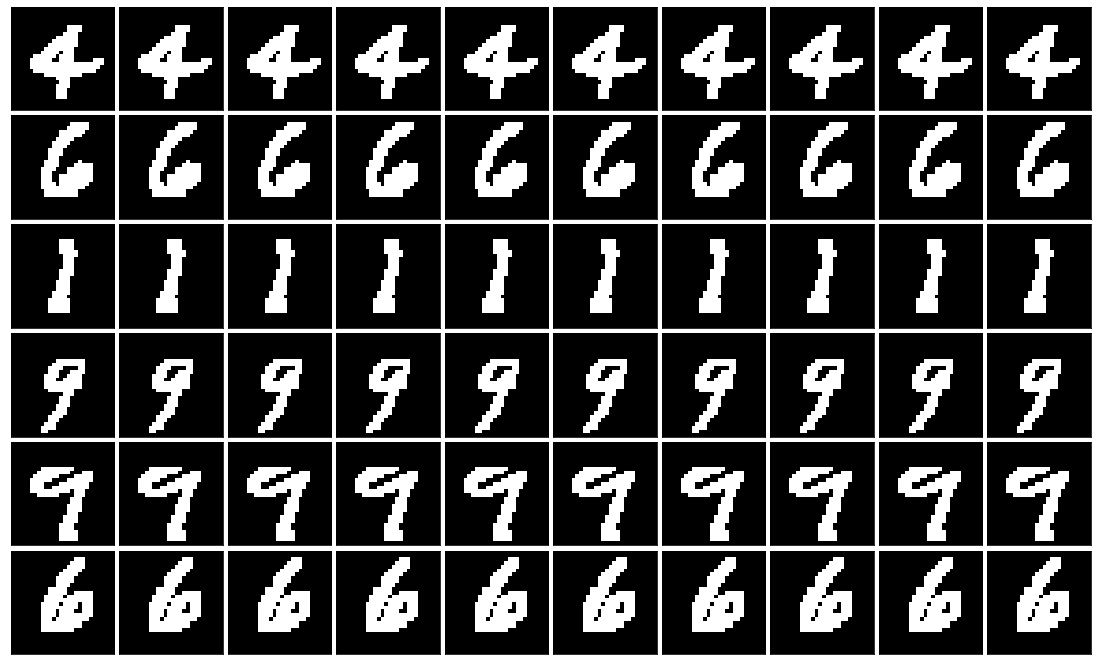

In [51]:
B = 3 # dummy batch size
S = 2 # dummy sample size
T = 10
frame_pixels = 64
mnist_pixels = 28
MNIST_DIR = '/data/hao/apg_data/mnist/' ## dir of the mnist data files
AT = Affine_Transformer(frame_pixels=frame_pixels,
                        digit_pixels=mnist_pixels,
                        CUDA=False,
                        DEVICE=None)
## initialize the bmnist generator
simulator = Sim_BMNIST(timesteps=T, 
                       num_digits=1, 
                       frame_size=frame_pixels, 
                       delta_t=0.3,
                       chunk_size=1)
z_where = []
for i in range(B*S):
    x0 = Uniform(-1, 1).sample((1, 2))
    X, _ = simulator.sim_trajectory(init_xs=x0)
    z_where.append(X.unsqueeze(0))
z_where = torch.cat(z_where, 0).view(S, B, T, 2).unsqueeze(-2)
## load the MNIST data and draw S*B images from that dataset
mnist = simulator.load_mnist(MNIST_DIR=MNIST_DIR)
digit_sample = torch.from_numpy(mnist[150:150+S*B]).float().view(S, B, 28, 28).unsqueeze(-3)
visualize(images=digit_sample.repeat(1, 1, T, 1, 1).view(S*B, T, 28, 28), fs=15, num_cols=T, num_row=S*B)

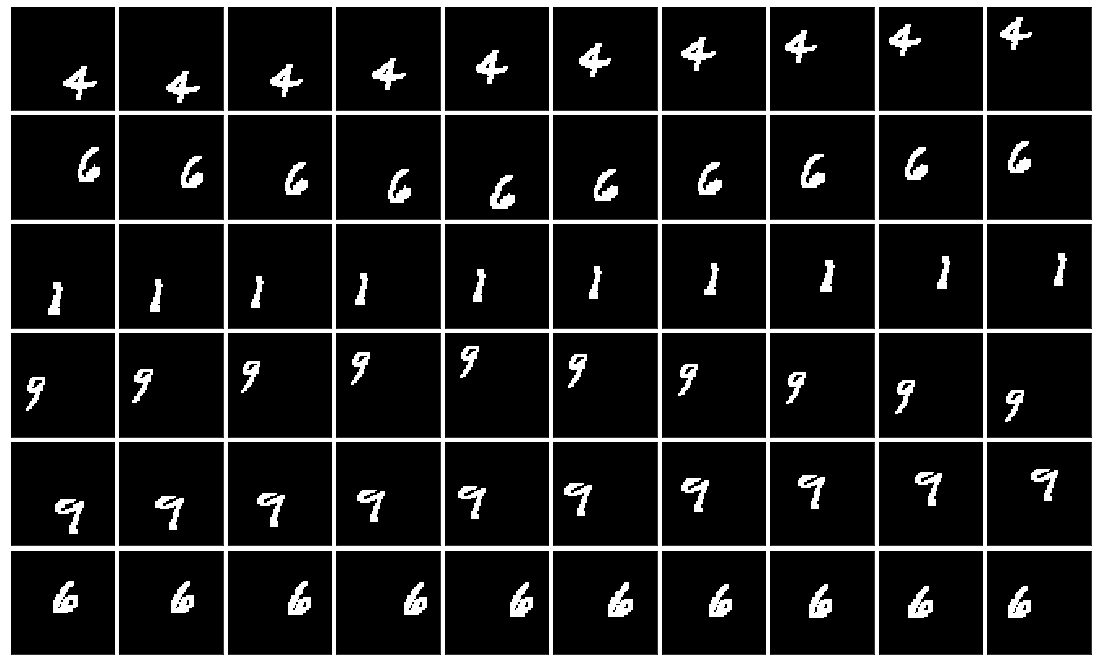

In [52]:
frames = AT.digit_to_frame(digit=digit_sample, z_where=z_where)
visualize(images=frames.view(S*B, T, 64, 64), fs=15, num_cols=T, num_row=S*B)

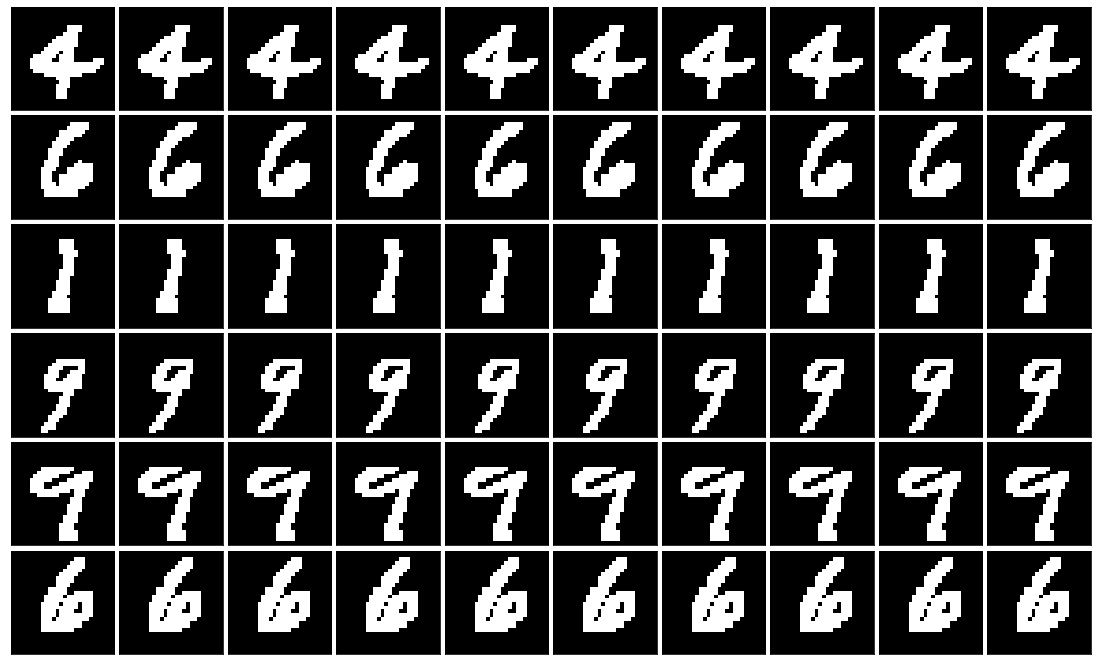

In [53]:
digit_re = AT.frame_to_digit(frames.squeeze(-3), z_where)
visualize(images=digit_re.squeeze(-3).view(S*B, T, 28, 28), fs=15, num_cols=T, num_row=S*B)

The original MNIST image:


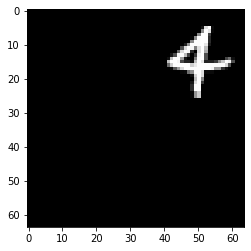

the translation from a MNIST image to a frame using pytorch functions:


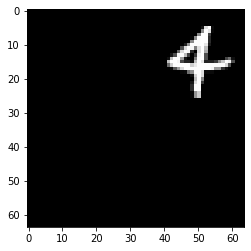

the translation from a frame back to a 28*28 MNIST image (by cropping) using pytorch functions:


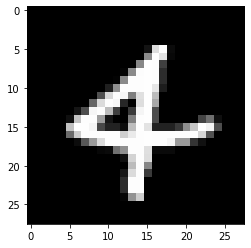

The translation from a MNIST image to a frame using analytical coordinate calculation:


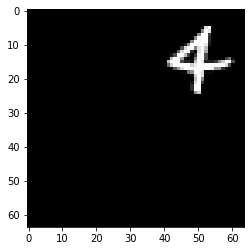

In [55]:
# digit to frame
print("The original MNIST image:")
single_sample = torch.from_numpy(mnist[150]).float()
plt.imshow(output.data.numpy(), cmap='gray')
plt.show()
print("the translation from a MNIST image to a frame using pytorch functions:")
theta = torch.Tensor([[64/28, 0, -1*(64/28)*(36/64)], [0, 64/28, 1*(64/28)*(36/64)]])
grid = affine_grid(theta.unsqueeze(0), torch.Size((1, 1, 64, 64)))
output = grid_sample(single_sample.unsqueeze(0).unsqueeze(0), grid, mode='nearest')[0,0]
plt.imshow(output.data.numpy(), cmap='gray')
plt.show()

print("the translation from a frame back to a 28*28 MNIST image (by cropping) using pytorch functions:")
theta2 = torch.Tensor([[(28/64), 0, 1*(36/64)], [0, (28/64), -1*(36/64)]])
grid2 = affine_grid(theta2.unsqueeze(0), torch.Size((1, 1, 28, 28)))
output2 = grid_sample(output.unsqueeze(0).unsqueeze(0), grid2, mode='nearest')[0,0]
plt.imshow(output2.data.numpy(), cmap='gray')
plt.show()

print("The translation from a MNIST image to a frame using analytical coordinate calculation:")
## analytical solution
x = 1.
y = 0.0
top = int(y * 36)
left = int(x * 36)
canvas = np.zeros((64, 64))
canvas[top:top+28, left:left+28] = single_sample
plt.imshow(canvas, cmap='gray')
plt.show()